In [45]:
# necessary library

%pylab inline

# read data to DataFrame
import pandas as pd

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# classifier LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#model selection
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

#learning
from sklearn.model_selection import learning_curve, ShuffleSplit

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

PATH_TO_DATA = './simplesentiment/'

import os
for dirname, _, filenames in os.walk(PATH_TO_DATA):
    for filename in filenames:
        print((os.path.join(dirname, filename)))

./simplesentiment/products_sentiment_train.tsv
./simplesentiment/products_sentiment_sample_submission.csv
./simplesentiment/products_sentiment_test.tsv


In [3]:
# load data

files = ['products_sentiment_train.tsv', 'products_sentiment_test.tsv']

train =  pd.read_csv(PATH_TO_DATA+files[0], sep = '\t', header = None, names = ['text', 'target'])

# train, taget, test
X = train.text
y = train.target

In [18]:
# data transformer - vectorizer
from nltk.tokenize.casual import casual_tokenize
vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    #     min_df = 2,
    tokenizer=casual_tokenize,
    #     stop_words = stops,
    #     max_df = 0.9,
    binary=True,
    sublinear_tf=True)

In [19]:
# split data
def split_data(X, y, rs):
    test_portion = 0.40
    return train_test_split(X,
                            y,
                            test_size=test_portion,
                            random_state=int(rs),
                            shuffle=True,
                            stratify=y)

# data transformation
def transform_data(train, validation):
    vectorizer.fit(train)
    return vectorizer.transform(train), vectorizer.transform(validation)

In [20]:
lda = LinearDiscriminantAnalysis(
    solver='eigen',
    shrinkage='auto'
)

In [21]:
def search_decision_value(X, y, classifier, n_seeds = 10):
    """Search optimal decision value for classification"""
    # set of decision values [0..1]
    ts = np.linspace(0.0, 1.0, 101)
    # accuracy, decision value for every data split (split by random seed)
    result = []
    for r_seed in np.linspace(1, 1000, n_seeds).astype(int):
        # split data to train/validation sets
        X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)
        # transform data to numerical values
        Xt_train, Xt_validation = transform_data(X_train, X_validation)
        # fit classifier with train data
        classifier.fit(Xt_train.todense(), y_train)
        # get predictions as probabilities [0..1]
        probabilities = classifier.predict_proba(Xt_validation.todense())[:, 1]
        # accuracy for every decision value
        accuracies = []
        for t in ts:
            predictions = (probabilities > t).astype(int)
            accuracies.append(accuracy_score(y_val, predictions))
        # store result as max accuracy and correspondent decision value
        result.append((np.max(accuracies), ts[np.argmax(accuracies)], r_seed))
#     return result , df
    return result

In [30]:
%%time
# decision value
import warnings
warnings.filterwarnings("ignore")

result = search_decision_value(X, y, lda, n_seeds=20)

CPU times: user 13min 25s, sys: 14.5 s, total: 13min 39s
Wall time: 3min 38s


In [31]:
# decision value
print(f"{np.array(result)[:,1].mean().round(2)} +/- {np.array(result)[:,1].std().round(2)}")

0.39 +/- 0.15


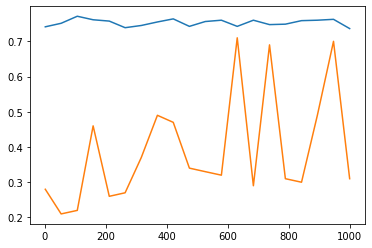

In [32]:
# plots accuracy/decision values
plt.plot(np.array(result)[:,2], np.array(result)[:,0])
plt.plot(np.array(result)[:,2], np.array(result)[:,1])

In [11]:
def accuracy_by_decision(X, y, classifier, n_seeds = 10, decision = 0.5):
    """Accuracy for every data split (split by random seed)"""
    result = []
    for r_seed in np.linspace(1, 1000, n_seeds).astype(int):
        # split data to train/validation sets
        X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)
        # transform data to numerical values
        Xt_train, Xt_validation = transform_data(X_train, X_validation)
        # fit classifier with train data
        classifier.fit(Xt_train.todense(), y_train)
        # get predictions as probabilities [0..1]
        probabilities = classifier.predict_proba(Xt_validation)[:, 1]
        predictions = (probabilities > decision).astype(int)
        # store result as accuracy
        result.append((accuracy_score(y_val, predictions), r_seed))
    
    return result

0.7453749999999999
CPU times: user 7min 15s, sys: 8.41 s, total: 7min 24s
Wall time: 1min 58s


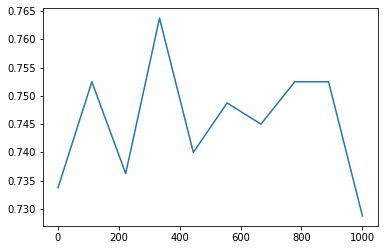

In [33]:
%%time
# decision value
result = accuracy_by_decision(X, y, lda, n_seeds=10, decision=0.39)

# plots accuracy/decision values
plt.plot(np.array(result)[:,1], np.array(result)[:,0])
print(np.array(result)[:,0].mean())

In [13]:
# draw accuracy plot by decision value
def draw_accuracy_by_decision_value(X, y, classifier, r_seed = 10):
    """Draw accuracy plot by decision value"""
    # set of decision values [0..1]
    ts = np.linspace(0.0, 1.0, 101)
    # split data to train/validation sets
    X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)
    # transform data to numerical values
    Xt_train, Xt_validation = transform_data(X_train, X_validation)
    # fit classifier with train data
    classifier.fit(Xt_train.todense(), y_train)
    # get predictions as probabilities [0..1]
    probabilities = classifier.predict_proba(Xt_validation.todense())[:, 1]
    # accuracy for every decision value
    accuracies = []
    for t in ts:
        predictions = (probabilities > t).astype(int)
        accuracies.append(accuracy_score(y_val, predictions))
    # store result as max accuracy and correspondent decision value
    plt.plot(ts, accuracies)
#     plt.show()

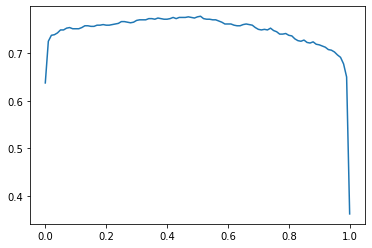

In [34]:
draw_accuracy_by_decision_value(X, y , lda, 11)

In [65]:
%%time
classifier = lda
t = 0.45

Xt = vectorizer.fit_transform(X)
classifier.fit(Xt.todense(), y)
probabilities = classifier.predict_proba(Xt.todense())[:, 1]
predictions = (probabilities > t).astype(int)
accuracy_score(y, predictions)

CPU times: user 1min 40s, sys: 1.45 s, total: 1min 41s
Wall time: 27.3 s


0.8555

In [56]:
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(lda, Xt.todense(), y, n_jobs=4, cv = 3, shuffle = True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

_, ax = plt.subplots(1, 1, figsize=(20, 5))
# Plot learning curve
ax.grid()
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax.legend(loc="best")